In [408]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture    
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,mean_squared_error
from sklearn.preprocessing import LabelEncoder, FunctionTransformer,StandardScaler,MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline  
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.compose import ColumnTransformer 
from scipy.stats import kurtosis  

from scipy import stats
from sklearn.compose import ColumnTransformer






In [409]:
import random 
random.seed(42)

In [410]:
#Loading Dataset for CSV 
spotify_df=pd.read_csv('spotify-2023.csv', encoding='ISO-8859-1')
marketing_df=pd.read_csv("marketing_campaign.csv",sep="\t") 

In [411]:
#Marketing Campaign 
# Creating are "target class"
marketing_df['AcceptedAny'] = (marketing_df[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5',"Response"]].sum(axis=1) > 0).astype(int)

# One hot encoding marital status
relationship_dict = {
    'Single': 0,
    'Together': 1,
    'Married': 1,
    'Divorced':0,
    'Widow': 0,
    'Alone': 0,
    'Absurd': 0,
    'YOLO': 0
}

marketing_df['Marital_Status'] = marketing_df['Marital_Status'].map(relationship_dict)


# Target Encoding for Education 
education_mapping = {
    'Basic': 0, 
    'Graduation': 1, 
    "2n Cycle":2,
    "Master":2,
    "Phd":3}


# transforming thet amount to being what is the distribution of their porchases money wise
marketing_df['Education'] = marketing_df['Education'].map(education_mapping)


marketing_df["Kidhome"]=marketing_df["Kidhome"]+marketing_df['Teenhome']


# Creating the 'birth_eras' column based on the bins
marketing_df['birth_eras'] =  2014 - marketing_df['Year_Birth']




marketing_df['NumAllPurchases'] = marketing_df['NumWebPurchases']+marketing_df['NumCatalogPurchases']+marketing_df['NumStorePurchases']

# Converting "Valance" into four classes 
bins = [-1, 20, 40, 60, 80, 101]
labels = [0, 1, 2, 3, 4]  # Numeric labels corresponding to each bin

# Use pd.cut to bin the data and assign the numeric labels directly
spotify_df['valence_%'] = pd.cut(spotify_df['valence_%'], bins=bins, labels=labels, right=True)




# Encoding Some of the Categorical variables
#Spotify 
# One hot encode Keys
spotify_df = pd.get_dummies(spotify_df, columns=['key'],dtype=int) 



# Label Encoding for mode 
mode_mapping = {'Major': 0, 'Minor': 1}

spotify_df['mode'] = spotify_df['mode'].map(mode_mapping)



In [412]:
#Drops Uneeded Categories and rows with null values, and the first column from one hot encoding

#Spotify Removal Of Uneeded 
spotify_df.drop(columns=['in_spotify_playlists', 'in_spotify_charts', 'streams',
                           'in_apple_playlists', 'in_apple_charts',
                           'in_deezer_charts', 'in_shazam_charts',"track_name","artist(s)_name","in_deezer_playlists","artist_count","released_day","released_year","released_month",'key_A'],axis =1,inplace=True) 
spotify_df.dropna(inplace=True)

#Marketing Removal Of Uneeded 
marketing_df.drop(columns=["ID",'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', "Year_Birth","Teenhome","Recency","Dt_Customer",'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5','Response',"Z_CostContact","Z_Revenue"],axis =1,inplace=True) 
marketing_df.dropna(inplace=True)


In [413]:

spotify_df = spotify_df.apply(pd.to_numeric,errors='coerce') 
marketing_df=marketing_df.apply(pd.to_numeric,errors='coerce')  

spotify_df.dropna(inplace=True) 
marketing_df.dropna(inplace=True)

In [414]:
columns_to_check = ["Income"]


z_scores = np.abs(stats.zscore(marketing_df[columns_to_check]))

threshold = 3


marketing_df = marketing_df[(z_scores < threshold).all(axis=1)]


In [415]:
x_spotify=spotify_df.drop(columns=["valence_%"])
y_spotify=spotify_df["valence_%"]
x_marketing= marketing_df.drop(columns=['AcceptedAny'])
y_marketing=marketing_df['AcceptedAny']


In [416]:
print(len(x_marketing.iloc[0]))
print(len(x_spotify.iloc[0]))

14
18


In [417]:
# Creates the Scaling Preproccesor for X Values
standard_categories = ['bpm']

percentage_categories = [ 'danceability_%', 'energy_%', 'acousticness_%', 
                      'instrumentalness_%', 'liveness_%']

# Define the transformers

def divide_by_100(X):
    return X / 100 

scaling_pipeline = Pipeline(steps=[
    ('standard_scaling', RobustScaler()),
    ('min_max_scaling', MinMaxScaler())    
])

preprocessor_spotify = ColumnTransformer(
    transformers=[
        ('standard', scaling_pipeline, standard_categories), 
        ('percentage', scaling_pipeline, percentage_categories), 
         
    ], 
    remainder='passthrough', 
    force_int_remainder_cols=False  
)


standard_categories = ['Education', 'Income', 'Kidhome', 'MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumAllPurchases', 'NumWebVisitsMonth',"birth_eras"
       ]  

preprocessor_marketing = ColumnTransformer(
    transformers=[
        ('standard', scaling_pipeline, standard_categories),   
           
    ], 
    remainder='passthrough', 
    force_int_remainder_cols=False
)



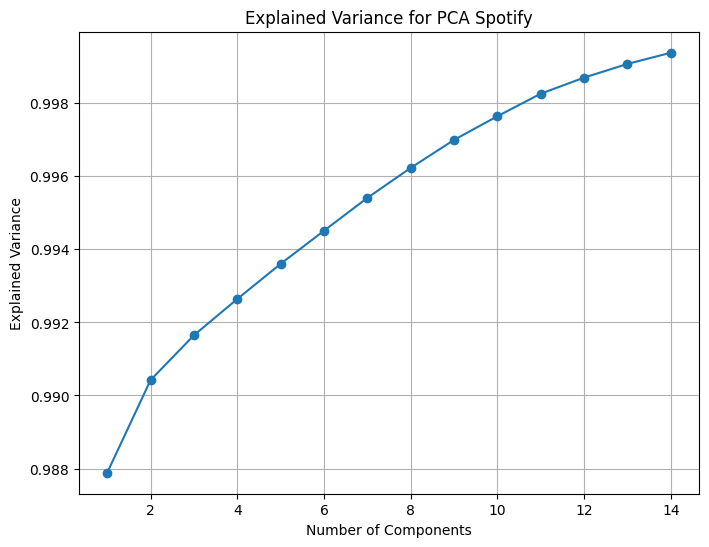

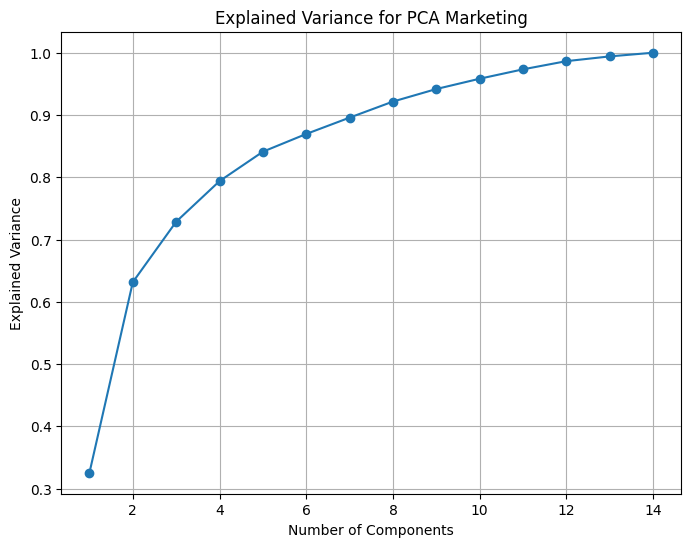

In [418]:
X_spotify = preprocessor_spotify.fit_transform(x_spotify)
X_marketing = preprocessor_marketing.fit_transform(x_marketing)


def plot_pca_explained_variance(X,name):
    explained_variances = []
    components_range = range(1, 15)  
    
    for n in components_range:
        pca = PCA(n_components=n,random_state=42)
        pca.fit(X)
        explained_variances.append(np.sum(pca.explained_variance_ratio_))
    
    # Plot the explained variance for each number of components 
    plt.figure(figsize=(8, 6))
    plt.plot(components_range, explained_variances, marker='o')
    plt.title(f'Explained Variance for PCA {name}')
    plt.xlabel('Number of Components')
    plt.ylabel('Explained Variance') 
    plt.grid(True)
    plt.show()


plot_pca_explained_variance(X_spotify,"Spotify") 
plot_pca_explained_variance(X_marketing,"Marketing")



In [419]:
X_spotify[1]

array([0.19148936, 0.65753425, 0.73863636, 0.07216495, 0.        ,
       0.07446809, 0.        , 4.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        ])

c:\Users\Joshu\OneDrive\Documents\GitHub\cs-7641-2025-spring-jwidjanarko3\.venv\lib\site-packages\sklearn\random_projection.py:411: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (14 < 15).The dimensionality of the problem will not be reduced.
  warnings.warn(
c:\Users\Joshu\OneDrive\Documents\GitHub\cs-7641-2025-spring-jwidjanarko3\.venv\lib\site-packages\sklearn\random_projection.py:411: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (14 < 16).The dimensionality of the problem will not be reduced.
  warnings.warn(
c:\Users\Joshu\OneDrive\Documents\GitHub\cs-7641-2025-spring-jwidjanarko3\.venv\lib\site-packages\sklearn\random_projection.py:411: DataDimensionalityWarning: The number of components is higher than the number of features: n_features < n_components (14 < 17).The dimensionality of the problem will not be reduced.
  warnings.warn(
c:\User

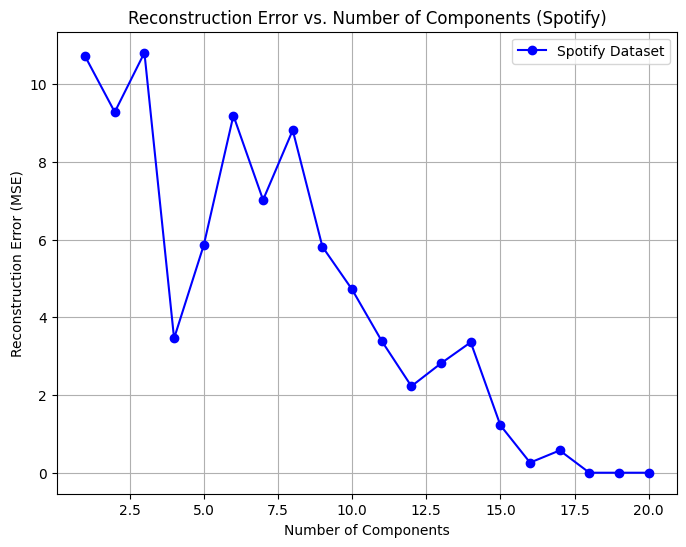

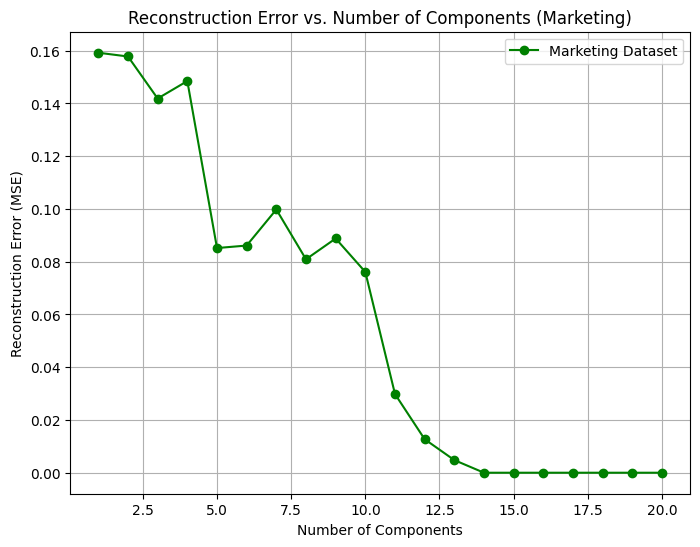

In [ ]:
X_spotify = preprocessor_spotify.fit_transform(x_spotify)
X_marketing = preprocessor_marketing.fit_transform(x_marketing)

reconstruction_errors_spotify = []
reconstruction_errors_marketing = [] 



for n_components in range(1, 21):
    
    transformer_spotify = GaussianRandomProjection(n_components=n_components,random_state=42)
    transformer_marketing = GaussianRandomProjection(n_components=n_components,random_state=42) 

   
    X_spotify_reduced = transformer_spotify.fit_transform(X_spotify)
    X_spotify_reconstructed = transformer_spotify.inverse_transform(X_spotify_reduced)
    mse_spotify = mean_squared_error(X_spotify, X_spotify_reconstructed)
    reconstruction_errors_spotify.append(mse_spotify)
    

    X_marketing_reduced = transformer_marketing.fit_transform(X_marketing)
    X_marketing_reconstructed = transformer_marketing.inverse_transform(X_marketing_reduced)
    mse_marketing = mean_squared_error(X_marketing, X_marketing_reconstructed)
    reconstruction_errors_marketing.append(mse_marketing)

# Plot for Spotify Dataset
plt.figure(figsize=(8, 6))
plt.plot(range(1, 21), reconstruction_errors_spotify, label='Spotify Dataset', marker='o', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error (MSE)')
plt.title('Reconstruction Error vs. Number of Components (Spotify)')
plt.grid(True)
plt.legend()
plt.show()

# Plot for Marketing Dataset
plt.figure(figsize=(8, 6))
plt.plot(range(1, 21), reconstruction_errors_marketing, label='Marketing Dataset', marker='o', color='g')
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error (MSE)')
plt.title('Reconstruction Error vs. Number of Components (Marketing)')
plt.grid(True)
plt.legend()
plt.show()


c:\Users\Joshu\OneDrive\Documents\GitHub\cs-7641-2025-spring-jwidjanarko3\.venv\lib\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
c:\Users\Joshu\OneDrive\Documents\GitHub\cs-7641-2025-spring-jwidjanarko3\.venv\lib\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
c:\Users\Joshu\OneDrive\Documents\GitHub\cs-7641-2025-spring-jwidjanarko3\.venv\lib\site-packages\sklearn\decomposition\_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


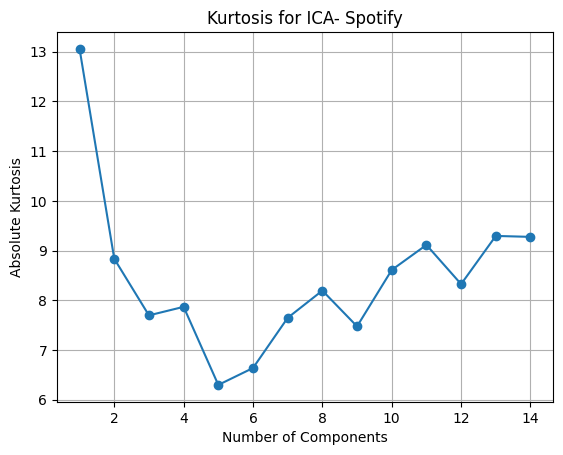

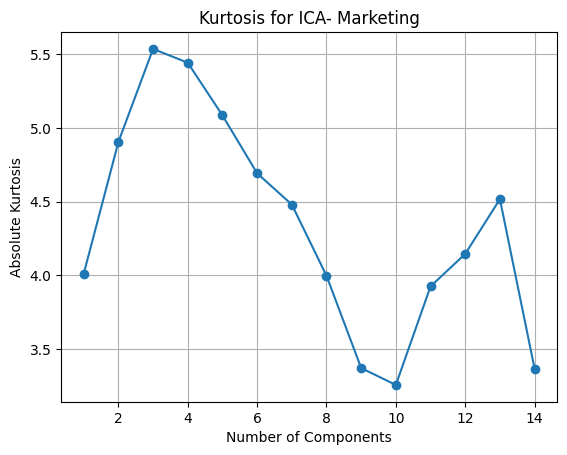

In [421]:
# Define a function to plot absolute kurtosis for ICA 
X_spotify = preprocessor_spotify.fit_transform(x_spotify)
X_marketing = preprocessor_marketing.fit_transform(x_marketing)
def plot_ica_kurtosis(X,name):
    kurtosis_values = []
    components_range = range(1, 15)  
    for n in components_range:
        ica = FastICA(n_components=n,random_state=42)
        ica.fit(X)
        # Compute the absolute average kurtosis 

        kurtosis_values.append(np.mean(np.abs(kurtosis(ica.components_, axis=1))))
    
    # Plot the kurtosis for each number of components
    plt.plot(components_range, kurtosis_values, marker='o')
    plt.title(f'Kurtosis for ICA- {name}')
    plt.xlabel('Number of Components')
    plt.ylabel('Absolute Kurtosis') 
    plt.grid(True)
    plt.show()

# Call the function for the Spotify dataset
plot_ica_kurtosis(X_spotify,"Spotify")

# Call the function for the Marketing dataset
plot_ica_kurtosis(X_marketing,"Marketing")

In [422]:
X_spotify = x_spotify
X_marketing = x_marketing



# Function to create a pipeline and get components
def get_components(preproccessor,dim_reduction_method, X):
    # Apply preprocessing and dimensionality reduction
    pipeline = Pipeline(steps=[
        ('preprocessor', preproccessor),  # Apply the preprocessor
        ('dim_reduction', dim_reduction_method)  # Apply PCA/RP/ICA
    ])
    
    # Fit the pipeline to get the transformed data
    pipeline.fit(X)
    
    # Return the components (transformed data)
    transformed_data = pipeline.transform(X)
    return transformed_data 

#Spotify
pca = PCA(n_components=6,random_state=42)  
rp = GaussianRandomProjection(n_components=10,random_state=42)  
ica = FastICA(n_components=1,random_state=42) 

# Get the components (transformed data) for PCA, RP, and ICA
transformed_pca_spotify = get_components(preprocessor_spotify,pca, X_spotify)
transformed_rp_spotify = get_components(preprocessor_spotify,rp, X_spotify)
transformed_ica_spotify = get_components(preprocessor_spotify,ica, X_spotify)

# Print the components for each transformation (can adjust to inspect or save)
print("Transformed data with PCA (Spotify):\n", transformed_pca_spotify)
print("Transformed data with RP (Spotify):\n", transformed_rp_spotify)
print("Transformed data with ICA (Spotify):\n", transformed_ica_spotify)

#marketing  
pca = PCA(n_components=2,random_state=42)  
rp = GaussianRandomProjection(n_components=11,random_state=42)  
ica = FastICA(n_components=3,random_state=42) 

# Repeat the process for Marketing data
transformed_pca_marketing = get_components(preprocessor_marketing,pca, X_marketing)
transformed_rp_marketing = get_components(preprocessor_marketing,rp, X_marketing)
transformed_ica_marketing = get_components(preprocessor_marketing,ica, X_marketing) 

print("Transformed data with PCA (Marketing):\n", transformed_pca_marketing)
print("Transformed data with RP (Marketing):\n", transformed_rp_marketing)
print("Transformed data with ICA (Marketing):\n", transformed_ica_marketing)

Transformed data with PCA (Spotify):
 [[-6.13241330e+00 -2.90186214e-01 -6.67980099e-02 -5.41672691e-02
   2.53361195e-01 -4.91112681e-01]
 [-6.13067111e+00 -3.93369005e-01  9.47510887e-01  1.65165184e-02
   9.82896130e-03 -2.04992298e-02]
 [-4.13444185e+00 -3.53553591e-01 -1.79397056e-01 -2.63296196e-01
  -4.89735509e-01 -4.07087600e-01]
 ...
 [-4.13022923e+00 -3.96947275e-01  9.47263272e-01  2.44803482e-02
   1.63142827e-02 -3.57742323e-02]
 [-5.13012207e+00 -3.89196517e-01  9.55651045e-01  2.41778182e-02
   3.23596781e-02 -5.40930439e-02]
 [-5.12968932e+00  6.95107033e-01 -5.98830752e-02 -2.12143846e-02
  -5.19939510e-03  1.56147281e-01]]
Transformed data with RP (Spotify):
 [[ 1.4972251   0.13116339 -1.39468721 ...  0.79283416  0.28230657
  -0.9283238 ]
 [ 1.00604801 -0.09463851 -1.22307008 ...  0.18703534  0.39714218
  -0.79916792]
 [ 1.13995234 -0.02875039 -0.85527061 ...  0.73395967  0.17720778
  -0.98198961]
 ...
 [ 1.4564133  -0.1046198  -1.45957493 ...  0.46643938  0.68876723